In [7]:
import torchvision
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import transforms,datasets,models
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [8]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
kaggle.json


In [9]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [10]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

In [11]:
from random import shuffle, seed; seed(10);

In [12]:
class CatDog(Dataset):
  def __init__(self,folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]
    shuffle(self.fpaths)
    self.normalize = transforms.Normalize(mean=[0.485,0.456, 0.406] ,
                                          std=[0.229, 0.224, 0.225])
    self.targets = [image.split('/')[-1].startswith('dog') for image in self.fpaths]
  def __len__(self):
    return len(self.targets)
    
  def __getitem__(self,ix):
    image = self.fpaths[ix]
    target = self.targets[ix]
    img = (cv2.imread(image)[:,:,::-1])
    img = cv2.resize(img,(224,224))
    img = torch.tensor(img/255)
    img = img.permute(2,0,1)
    img = self.normalize(img)

    return img.float().to('cuda') , torch.tensor([target]).float().to('cuda')


In [13]:
train_data = CatDog(train_data_dir)

tensor([0.], device='cuda:0')


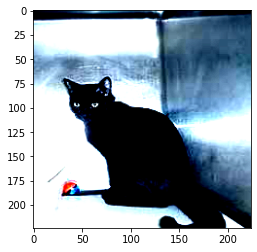

In [14]:
im, label = train_data[100]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [15]:
def build_model():
  model = models.vgg16(pretrained = True)
  for parm in model.parameters():
    parm.requires_grad = False 
  
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128,1),
      nn.Sigmoid(),
  )

  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

  return model.to('cuda'), loss_fn, optimizer

In [16]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()
  return batch_loss.item()

In [17]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [18]:
def get_data():
  train = CatDog(train_data_dir)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
  val = CatDog(test_data_dir)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
  return trn_dl, val_dl

In [19]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = build_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [20]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(10):
  print(f'Epoch {epoch+1}:')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, \
    loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print(f'Train Loss: {train_epoch_loss:0.3f}')
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  print(f'Train Accuracy: {train_epoch_accuracy*100:0.0f}%')
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)
  print(f'Validation Accuracy: {val_epoch_accuracy*100:0.0f}%')
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  print('<--------------------------------------------------------->')

Epoch 1:
Train Loss: 0.224
Train Accuracy: 98%
Validation Accuracy: 97%
<--------------------------------------------------------->
Epoch 2:
Train Loss: 0.046
Train Accuracy: 99%
Validation Accuracy: 98%
<--------------------------------------------------------->
Epoch 3:
Train Loss: 0.028
Train Accuracy: 99%
Validation Accuracy: 98%
<--------------------------------------------------------->
Epoch 4:
Train Loss: 0.021
Train Accuracy: 100%
Validation Accuracy: 99%
<--------------------------------------------------------->
Epoch 5:
Train Loss: 0.015
Train Accuracy: 100%
Validation Accuracy: 99%
<--------------------------------------------------------->
Epoch 6:
Train Loss: 0.012
Train Accuracy: 100%
Validation Accuracy: 99%
<--------------------------------------------------------->
Epoch 7:
Train Loss: 0.009
Train Accuracy: 100%
Validation Accuracy: 99%
<--------------------------------------------------------->
Epoch 8:
Train Loss: 0.007
Train Accuracy: 100%
Validation Accuracy: 99%

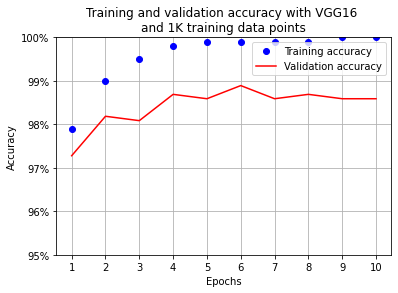

In [21]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()